Normalize = True (set to "normalize=False" to disable normalization)
Threshold = 2.576 (default: p=.99) (set to "threshold=x" to alter threshold value to x)
Found 24 exceptional values with a threshold of 2.576.
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


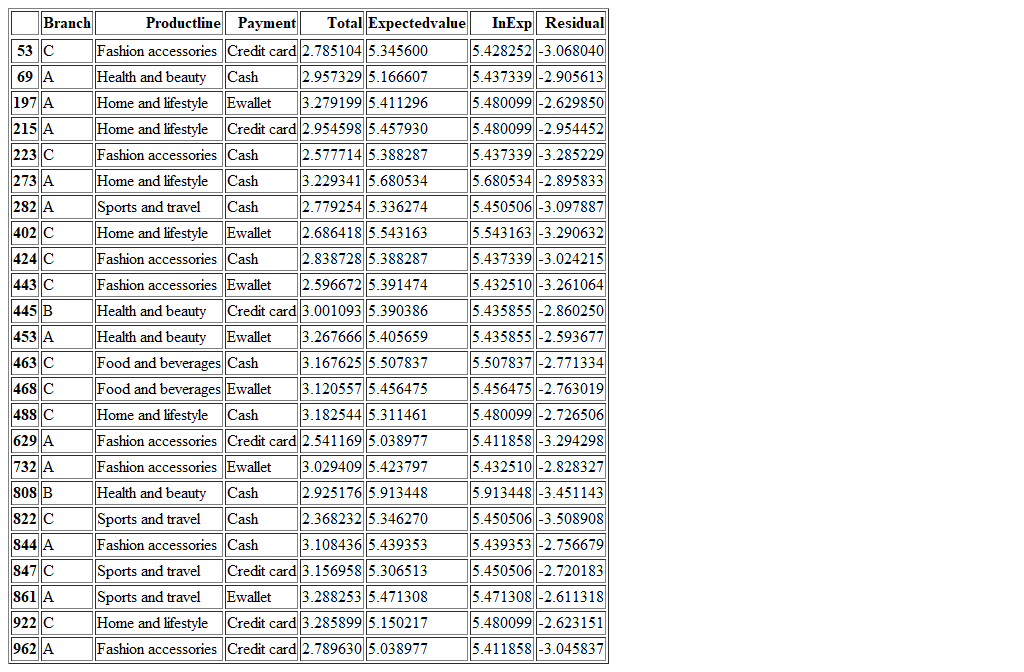

In [1]:
#Import required libraries
import pandas as pd
import numpy as np

#Select datafile to import and columns to analyse
file = 'supermarket_sales.csv'
columns = ['Branch', 'Product line', 'Payment', 'Total']

#Import PowerBI data into DataFrame, select columns and remove spaces from column headers
#Dependent variable should be the last column in the file or in the column selection
#Normalization of the data is optional but enabled by default
def import_data(file, *args, normalize=True):
    data = pd.read_csv(file)
    df = pd.DataFrame(data)
    columns = list(*args) #Create a list of selected columns
    df = df[columns]
    df.columns = df.columns.str.replace(' ', '') #Remove spaces from column names
    if len(df.columns) == 0:
        print('Please enter columns to be considered') #Give a warning if no colomns are selected
    else:
        #Optionally normalize the data
        print(f'Normalize = {normalize} (set to "normalize=False" to disable normalization)')
        #Returns the log value of the 'Total' column as output
        def normalize_data(df):
            df['Total'] = np.log(df['Total'])
            return df
        if normalize == True:
            normalize_data(df)
        return df

#Computes the expected values for the 'Total' column in the DataFrame, by the use of a main-effects ANOVA
#Input is a DataFrame with a 'Total' column as last column
#Output is a DataFrame with an added column named 'Expectedvalue'
def compute_expected_values(df):
    dimension_means = {}
    x = list(df.columns[:-1]) #List all column names, excluding the 'Total' column
    y = df.groupby(x)[df.columns[-1]].mean() #Creating a series of every combination of the selected columns and calculating the mean value of 'Total' per combination
    for item in range(0, len(y)):
        dimension_means[y.index[item]] = y.values[item] #Save all groupings and their respective means in a dictionary as a key, value pair
    z = []
    for item in range(0, len(df)):
        z.append(df.values[item][0:(len(df.columns) - 1)]) #For each row in the data, list the combination of column headers for that particular row
    #Correcting trailing ',' for single tuple values in 1 dimensional data, which is added by default
    if len(x) == 1:
        z = ([x[0] for x in z])
    df['Expectedvalue'] = tuple(z) #Make a new column in the DataFrame that contains a tuple of the respective combination of column headers for every row in the DataFrame
    df['Expectedvalue'] = df['Expectedvalue'].map(dimension_means) #Map the respective mean values from the earlier created dictionary on the combination of column headers to create a column containing 'Expected Values'
    return df

#Computes the InExp value for a DataFrame by calculating main effects of all separate dimensions compared to the 'Expectedvalue'
#Input is a DataFrame containing columns named 'Total' and 'Expectedvalue'
#Output is a new column named InExp, which is the max of the main effects of separate dimensions and 'Expectedvalue'
def compute_InExp(df):
    #Disable SettingWithCopyWarning for chained assignment, wich is a redundant error warning that does not apply here
    pd.options.mode.chained_assignment = None
    #Calculate alt_means for separate dimensions
    alt_means = {}
    x = list(df.columns[:-1])
    for item in x[:-1]:
        y = df.groupby(item)[df.columns[-1]].mean() #Create a series of every individual dimension and calculate the mean value of 'Total' per dimension
        for item in range(0, len(y)):
            alt_means[y.index[item]] = y.values[item] #Save every dimension and their respective mean in a dictionary as a key, value pair
    #Create new DataFrame for comparison of dimension means and return InExp as max
    z = list(df.columns[:-2]) #List column names
    dfInx = df[z]
    for item in z:
        dfInx[item] = dfInx[item].map(alt_means) #Add a new column to the DataFrame for every dimension in the original data and map the values from the dictionary to each row in the respective columns
    dfInx['SelfExp'] = df['Expectedvalue'].astype(float) #Add the 'Expectedvalue' from the original DataFrame to this new DataFrame
    dfInx['InExp'] = dfInx.max(axis=1) #Select the max value from each row to determine the 'InExp' value
    df['InExp'] = dfInx['InExp'] #Add the 'InExp' column to the original DataFrame
    return df

#Computes residual values by subtracting the 'Expectedvalue' from the 'Total' and dividing this by the standard deviation of the data
#Input is a DataFrame containing 'Total' and 'Expectedvalue' columns
#Output is a DataFrame with an added column 'Residuals'
def compute_residual_values(df):
    #Calculate standard deviation
    v = sum((df['Total'] - df['Total'].mean())**2) / (len(df) - 1)
    sd = v**(0.5)
    try:
        df['Residual'] = df['Total'] - df['InExp'] / sd
    except Exception:
        df['Residual'] = df['Total'] - df['Expectedvalue'] / sd
    return df  

#Identifies exceptional values according to a certain threshold - default threshold value is 2.576 or p=.99
#Input is a DataFrame containing a column called 'Residual' containing residual values and optionally a threshold value
#Output is a DataFrame containing all the exceptional values and their indices
def identify_exceptional_values(df, threshold):
    print(f'Threshold = {threshold} (default: p=.99) (set to "threshold=x" to alter threshold value to x)')
    df = df[(df.Residual > threshold) | (df.Residual < -threshold)] #Select DataFrame rows on index
    print(f'Found {len(df)} exceptional values with a threshold of {threshold}.')
    return df

#Aggregrates all functions in one main function that can be called
#Input is optionally a different threshold value
#Output is an HTML render of a pandas DataFrame, containing all rows of interest
def main(threshold=2.576):
    result = import_data(file, columns)
    result = compute_expected_values(result)
    result = compute_InExp(result)
    result = compute_residual_values(result)
    result = identify_exceptional_values(result, threshold)
    
    html = result.to_html()#Render DataFrame as HTML

    import imgkit
    from IPython.display import Image
    imgkit.from_string(html, 'styled_table.png') #convert HTML to PNG
    return display(Image("styled_table.png"))
    
#Execute function
if __name__ == '__main__':
    main()